In [2]:
import collections
import io
import time
import math
import pyndri
import logging
import sys

import numpy as np

In [3]:
index = pyndri.Index('../index/')

In [4]:
def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            

# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


In [5]:
def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics


with open('../ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

In [6]:
with open('../ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('../index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

start_time = time.time()

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 44.47519540786743 seconds.


In [7]:
class PositionalLanguageModel:
    """Positional language model.
    
    Attributes:
        index: pyndry index for the entire collection.
        inverted_index: dict of term frequencies per document.
        col_freq: dict of term frequencies for the entire collection.
        doc_len: dict of documents lengths.
        doc_voc_size: dict of sizes of document vocabularies.
        sigma: sigma tuning parameter for the kernel.
        mu: tuning parameter to control Dirichlet smoothing interpolation.
    """

    def __init__(self, index: pyndri.Index, inverted_index: collections.defaultdict(dict),
                 col_freq: collections.defaultdict(int), doc_len: dict, doc_voc_size: dict, sigma: float, mu: float):
        """Initialize positional language model.
        
        Args:
            index: pyndry index for the entire collection.
            inverted_index: dict of term frequencies per document.
            col_freq: dict of term frequencies for the entire collection.
            doc_len: dict of documents lengths.
            doc_voc_size: dict of sizes of document vocabularies.
            sigma: sigma tuning parameter for the kernel.
            mu: tuning parameter to control Dirichlet smoothing interpolation.
        """
        self.index = index
        self.inverted_index = inverted_index
        self.col_freq = col_freq
        self.doc_len = doc_len
        self.doc_voc_size = doc_voc_size
        self.col_size = sum(col_freq)
        self.sigma = sigma
        self.mu = mu

    def score(self, int_doc_id: int, query_term_id: int, doc_term_freq: int)-> float:
        """Compute the score for a document and a query term.
        
        Args:
            int_doc_id: the document id.
            query_term_id: the query term id (assuming you have split the query to tokens).
            doc_term_freq: the document term frequency of the query term.
        Return:
            Maximum position-based score of a query given a document.
        """
        doc = self.index.document(int_doc_id)[1]
        
        # for each query term
        # for each position in the document
        # add the query log likelihood of each position up for that 
        
        
        return 0.0

    def kernel(self, i: int, j: int, t: str)-> float:
        """Compute the kernel between two positions in the document.
        
        Args:
            i: the position of a term.
            j: the second positionl
            t: the kernel type.

        Returns:
            the result of the kernel function.
        """
        if t == 'gaussian':
            return math.exp(- (i - j) ** 2 / 2 * self.sigma ** 2)
        else:
            raise ValueError('Kernel type not supported: {}'.format(t))

    def term_count(self, query_term_id: int, doc_term_id: int)-> float:
        return int(query_term_id == doc_term_id)



Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on NDCG@10, Mean Average Precision (MAP@1000), Precision@5 and Recall@1000.

For the language models, create plots showing NDCG@10 with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's subprocess.

In [50]:
import os
import collections

evaluation_measures = ['ndcg_cut_10', 'map_cut_1000', 'P_5', 'recall_1000']
eval_algorithms = ['ad_delta_0.1', 'bm25', 'dp_mu_500', 'jm_lambda_0.9', 'ad_delta_0.5', 'dp_mu_1000', 'jm_lambda_0.1', 'tfidf', 'ad_delta_0.9', 'dp_mu_1500', 'jm_lambda_0.5']
test_type = ['results_validation', 'results_test' ]

trec_eval_directory = '../trec_eval' # required dir format: trec_eval(results_test(...),results_validation(...))
scores = collections.defaultdict(lambda : collections.defaultdict(dict))


#GATHERING ALL NECESSARY SCORES
for directory in os.listdir(os.fsencode(trec_eval_directory)):
    for file in os.listdir(os.path.join(results_directory, directory)):
        for line in open(os.path.join(results_directory, directory,file)):
            evaluation_type, querry, score = line.split()
            if querry == 'all' and evaluation_type in evaluation_measures:
                    scores[os.fsdecode(directory)][os.fsdecode(file)[:-4]][evaluation_type] = score
                    
                    
                    

# ADJUSTING THE HYPERPARAMETERS BASED ON VALIDATION SET
val_maxim_algorithms = collections.defaultdict(lambda: collections.defaultdict(lambda: -1.0))
algor_name = collections.defaultdict(lambda: collections.defaultdict(lambda: None))

for eval_algorithm in scores['results_validation'].keys():
    for eval_measure in scores['results_validation'][eval_algorithm].keys():
        if float(scores['results_validation'][eval_algorithm][eval_measure]) > float(val_maxim_algorithms[eval_algorithm.split('_')[0]][eval_measure]):
            val_maxim_algorithms[eval_algorithm.split('_')[0]][eval_measure] = scores['results_validation'][eval_algorithm][eval_measure]
            algor_name[eval_algorithm.split('_')[0]][eval_measure] = eval_algorithm
    
    
# ADJUSTING THE HYPERPARAMETERS BASED ON VALIDATION SET
test_maxim_algorithms = collections.defaultdict(lambda: collections.defaultdict(lambda: -1.0))
test_maxim_algor_name = collections.defaultdict(lambda: collections.defaultdict(lambda: None))

for eval_algorithm in val_maxim_algorithms.keys():
    for eval_measure in val_maxim_algorithms[eval_algorithm].keys():
        test_maxim_algorithms[eval_algorithm][eval_measure] = scores['results_test'][algor_name[eval_algorithm][eval_measure]][eval_measure]
            
test_maxim_algorithms

defaultdict(<function __main__.<lambda>>,
            {'ad': defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
                         {'P_5': '0.0383',
                          'map_cut_1000': '0.0169',
                          'ndcg_cut_10': '0.0345',
                          'recall_1000': '0.1454'}),
             'bm25': defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
                         {'P_5': '0.4133',
                          'map_cut_1000': '0.2173',
                          'ndcg_cut_10': '0.4086',
                          'recall_1000': '0.6524'}),
             'dp': defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
                         {'P_5': '0.0483',
                          'map_cut_1000': '0.0191',
                          'ndcg_cut_10': '0.0454',
                          'recall_1000': '0.1396'}),
             'jm': defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
                         {'P_5': '0.0367',


In [52]:
scores

defaultdict(<function __main__.<lambda>>,
            {'results_test': defaultdict(dict,
                         {'ad_delta_0.1': {'P_5': '0.0367',
                           'map_cut_1000': '0.0160',
                           'ndcg_cut_10': '0.0332',
                           'recall_1000': '0.1378'},
                          'ad_delta_0.5': {'P_5': '0.0400',
                           'map_cut_1000': '0.0167',
                           'ndcg_cut_10': '0.0345',
                           'recall_1000': '0.1412'},
                          'ad_delta_0.9': {'P_5': '0.0383',
                           'map_cut_1000': '0.0169',
                           'ndcg_cut_10': '0.0349',
                           'recall_1000': '0.1454'},
                          'bm25': {'P_5': '0.4133',
                           'map_cut_1000': '0.2173',
                           'ndcg_cut_10': '0.4086',
                           'recall_1000': '0.6524'},
                          'dp_mu_1000': {'P_5':

/home/ruben-grab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice.
/home/ruben-grab/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


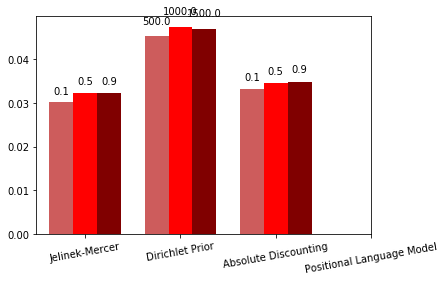

In [187]:
import matplotlib.pyplot as plt
class ExperimentSetup:
    def __init__(self, name, param_name, parameters, values):
        self.name = name
        self.param_name = param_name
        self.parameters = parameters
        self.values = values
        
language_models = ['jm','dp','ad','plm']
graph_data = collections.defaultdict(lambda: collections.defaultdict(lambda: []))
for key in scores['results_test'].keys():
    if key.split('_')[0] in language_models:
        graph_data[key.split('_')[0]]['values'].append(float(scores['results_test'][key]['ndcg_cut_10']))
        graph_data[key.split('_')[0]]['parameters'].append(key.split('_')[-1])
        
for key in graph_data.keys():
    graph_data[key]['parameters'] = np.array(graph_data[key]['parameters'], dtype=float)  # form array to numpy.array
    sort_indexes = np.argsort(graph_data[key]['parameters'])
    graph_data[key]['parameters'] = graph_data[key]['parameters'][sort_indexes]  # sort
    graph_data[key]['values'] = np.array(graph_data[key]['values'], dtype=float)[sort_indexes] # form array to numpy.array and sort
    
    
        
experiments = [ExperimentSetup("Jelinek-Mercer","λ",graph_data['jm']['parameters'],graph_data['jm']['values']),
                ExperimentSetup("Dirichlet Prior","μ",graph_data['dp']['parameters'],graph_data['dp']['values']),
                ExperimentSetup("Absolute Discounting","δ",graph_data['ad']['parameters'],graph_data['ad']['values']),
              ExperimentSetup("Positional Language Model","δ",graph_data['plm']['parameters'],graph_data['plm']['values'])]

# ExperimentSetup("Positional Language Model","μ",graph_data['plm']['parameters'],graph_data['jm']['values'])

def plot_results(experiments):
    ax = plt.subplot(111)
    ax.get_xaxis().set_visible(True)
    bar_width = 1
    
    label_x = []
    label_values = []
    padding=0

    for algorithm_index, experiment in enumerate(experiments):
        bars = np.arange(0,bar_width*(len(experiment.parameters)+1),bar_width)[:len(experiment.parameters)]
        mean = bars.mean()
        bars = bars - mean

        colors = ['indianred', 'red','maroon']
        rects1 = ax.bar(bars + padding, experiment.values, width = bar_width, color=colors, align='center')
        
        label_x.append(padding)
        label_values.append(experiment.name)
        
        padding += (bar_width*len(experiment.parameters)+bar_width) 
        
#       Attach a text label above each bar displaying its paramtere
        for index, rect in enumerate(rects1):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%s' % experiment.parameters[index],
                    ha='center', va='bottom')
    plt.xticks(label_x, label_values, rotation='10')
    
    plt.show()

plot_results(experiments)
